In [3]:
#import reguired libraries
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
# Set paths
original_base = r'C:\Users\gajje\OneDrive\Desktop\Major\Lung_diagnosis_files\Dataset\Dataset\Dataset\round-1\Level1\10%Base'
original_inbox = r'C:\Users\gajje\OneDrive\Desktop\Major\Lung_diagnosis_files\Dataset\Dataset\Dataset\round-1\Level2\Inbox'
original_outbox = r'C:\Users\gajje\OneDrive\Desktop\Major\Lung_diagnosis_files\Dataset\Dataset\Dataset\round-1\Level3\Outbox'

train_dir = r'temp_dataset\train'
test1_dir = r'temp_dataset\test1'  
test2_dir = r'temp_dataset\test2'  
test3_dir = r'temp_dataset\test3'  

# Clean and recreate folders
for folder in [train_dir, test1_dir, test2_dir, test3_dir]:
    shutil.rmtree(folder, ignore_errors=True)
    os.makedirs(folder, exist_ok=True)

# Function to split and copy image files
def split_and_copy(src_folder, dst_folder, split_ratio=1.0, split_type='random'):
    labels = os.listdir(src_folder)
    for label in labels:
        src_label_path = os.path.join(src_folder, label)
        dst_label_path = os.path.join(dst_folder, label)
        os.makedirs(dst_label_path, exist_ok=True)
        files = [f for f in os.listdir(src_label_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        files.sort()
        if split_type == 'random':
            files = random.sample(files, int(len(files) * split_ratio))
        elif split_type == 'first_half':
            files = files[:int(len(files) * split_ratio)]
        elif split_type == 'second_half':
            files = files[int(len(files) * split_ratio):]
        for f in files:
            shutil.copy(os.path.join(src_label_path, f), os.path.join(dst_label_path, f))

# Prepare splits
split_and_copy(original_base, train_dir, 0.9)
split_and_copy(original_base, test1_dir, 0.1)
split_and_copy(original_inbox, test2_dir)
split_and_copy(original_outbox, train_dir, 0.5, split_type='first_half')
split_and_copy(original_outbox, test3_dir, 0.5, split_type='second_half')



In [5]:
# Data generators
img_size = (128, 128)
batch_size = 16
datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test3_data = datagen.flow_from_directory(test3_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

Found 441 images belonging to 3 classes.
Found 324 images belonging to 3 classes.


In [6]:
# CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data, epochs=10)

C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.3198 - loss: 1.2656
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.3536 - loss: 1.0931
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.3533 - loss: 1.0937
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.3410 - loss: 1.0973
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.3934 - loss: 1.0831
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.3937 - loss: 1.0870
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.4291 - loss: 1.0908
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.3889 - loss: 1.0834
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.3968 - loss: 1.0638
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 293ms/step - accuracy: 0.4797 - loss: 1.0261


In [11]:
# CNN model using Functional API
from tensorflow.keras import layers, models

inputs = tf.keras.Input(shape=(128, 128, 3))
x = layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Conv2D(64, (3,3), activation='relu')(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Conv2D(128, (3,3), activation='relu')(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data, epochs=10)


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.3332 - loss: 1.1970
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 242ms/step - accuracy: 0.4084 - loss: 1.0881
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.4676 - loss: 1.0925
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.6301 - loss: 0.8886
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.7712 - loss: 0.5653
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.8793 - loss: 0.3165
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9635 - loss: 0.1032
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.9812 - loss: 0.0722
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 0.0107
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 0.0062


In [13]:
# Feature extraction model
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)

def extract_features(data_gen):
    features = []
    labels = []
    for _ in range(len(data_gen)):
        x, y = next(data_gen)
        f = feature_extractor.predict(x)
        features.append(f)
        labels.append(y)
    return np.vstack(features), np.argmax(np.vstack(labels), axis=1)

X_train_feat, y_train = extract_features(train_data)
X_test_feat, y_test = extract_features(test3_data)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━


 SVM Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.70      0.76       126
           1       0.58      0.72      0.65        72
           2       0.56      0.58      0.57       126

    accuracy                           0.66       324
   macro avg       0.66      0.67      0.66       324
weighted avg       0.67      0.66      0.66       324



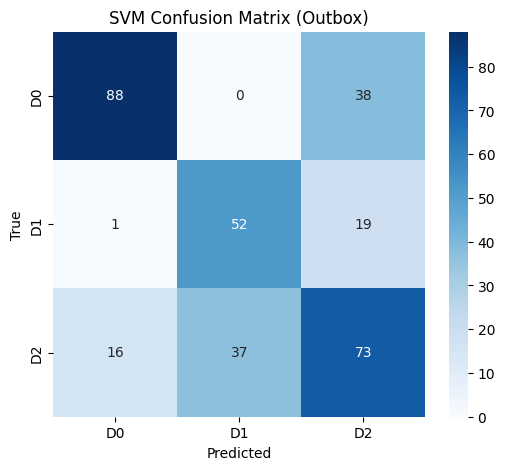


 Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.78      0.77       126
           1       0.67      0.54      0.60        72
           2       0.57      0.62      0.59       126

    accuracy                           0.66       324
   macro avg       0.67      0.65      0.65       324
weighted avg       0.67      0.66      0.66       324



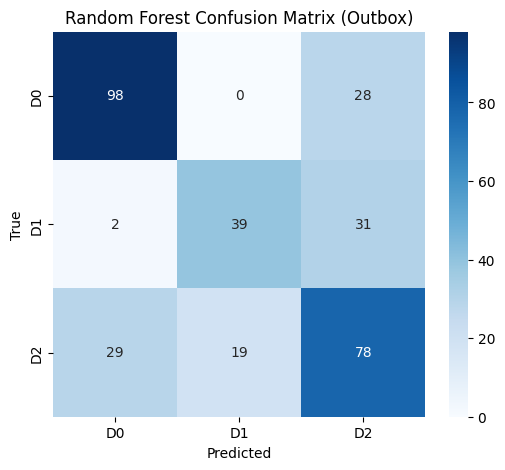


 K-Nearest Neighbors Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.71      0.80       126
           1       0.58      0.93      0.72        72
           2       0.65      0.59      0.62       126

    accuracy                           0.71       324
   macro avg       0.72      0.74      0.71       324
weighted avg       0.74      0.71      0.71       324



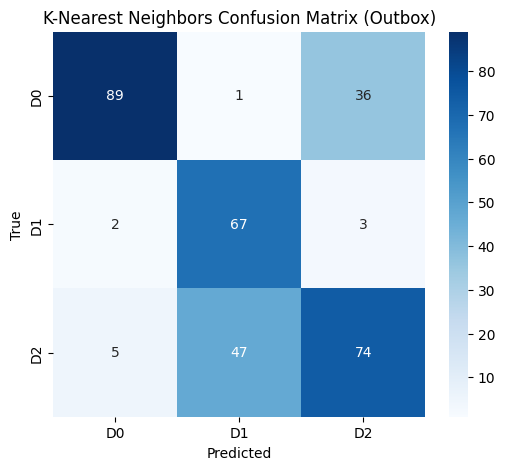

C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [09:36:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.89      0.81       126
           1       0.67      0.58      0.62        72
           2       0.65      0.57      0.61       126

    accuracy                           0.70       324
   macro avg       0.69      0.68      0.68       324
weighted avg       0.69      0.70      0.69       324



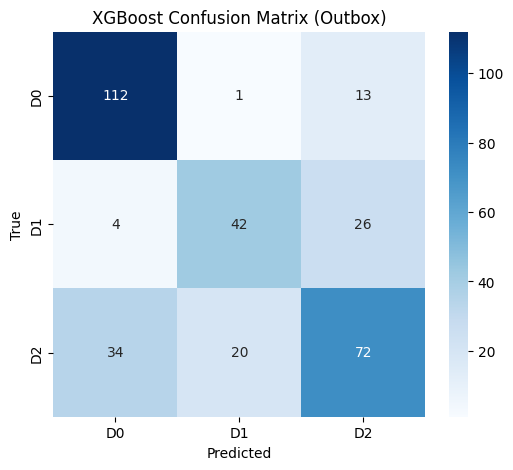


 Stacked Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.71      0.76       126
           1       0.57      0.96      0.72        72
           2       0.60      0.46      0.52       126

    accuracy                           0.67       324
   macro avg       0.67      0.71      0.67       324
weighted avg       0.69      0.67      0.66       324



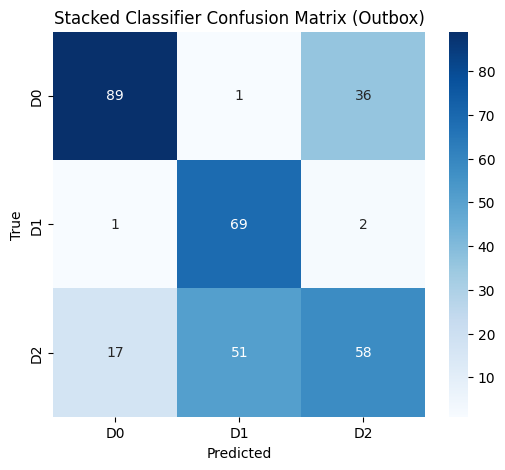

In [16]:
# Machine Learning models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n {name} Classification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test3_data.class_indices, yticklabels=test3_data.class_indices)
    plt.title(f'{name} Confusion Matrix (Outbox)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# 1. SVM
evaluate_model("SVM", SVC(kernel='rbf'), X_train_feat, y_train, X_test_feat, y_test)

# 2. Random Forest
evaluate_model("Random Forest", RandomForestClassifier(n_estimators=100), X_train_feat, y_train, X_test_feat, y_test)

# 3. KNN
evaluate_model("K-Nearest Neighbors", KNeighborsClassifier(n_neighbors=5), X_train_feat, y_train, X_test_feat, y_test)

# 4. XGBoost
evaluate_model("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), X_train_feat, y_train, X_test_feat, y_test)

# 5. Stacking Classifier
stack_model = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=50)),
        ('svm', SVC(probability=True)),
        ('knn', KNeighborsClassifier(n_neighbors=3))
    ],
    final_estimator=LogisticRegression()
)
evaluate_model("Stacked Classifier", stack_model, X_train_feat, y_train, X_test_feat, y_test)



 Stacked Classifier Report:
               precision    recall  f1-score   support

           0       0.81      0.73      0.77       126
           1       0.58      0.97      0.73        72
           2       0.61      0.43      0.50       126

    accuracy                           0.67       324
   macro avg       0.66      0.71      0.66       324
weighted avg       0.68      0.67      0.65       324



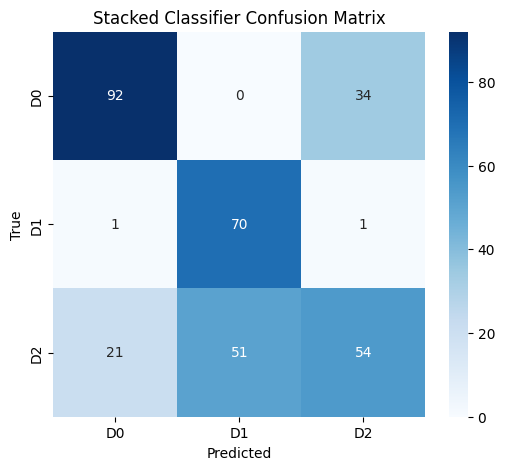

In [17]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Base learners
base_models = [
    ('svm', SVC(probability=True)),
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
]

# Meta-learner
meta_model = LogisticRegression()

# Stacking classifier
stack_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Train and evaluate
stack_model.fit(X_train_feat, y_train)
y_pred = stack_model.predict(X_test_feat)

# Classification report
print("\n Stacked Classifier Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test3_data.class_indices, yticklabels=test3_data.class_indices)
plt.title('Stacked Classifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [18]:
accuracy = stack_model.score(X_test_feat, y_test)
print(f"Stacked Classifier Accuracy: {accuracy * 100:.2f}%")


Stacked Classifier Accuracy: 66.67%


In [19]:
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestClassifier()
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(rf_model, param_grid, cv=5)
grid_search_rf.fit(X_train_feat, y_train)
print("Best Random Forest Parameters:", grid_search_rf.best_params_)


Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

# Base learners with hyperparameter tuning
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}


In [22]:
# # Meta-learner (try GradientBoostingClassifier or XGBClassifier)
# meta_model_updated = LogisticRegression()

# # Stacking classifier with updated models
# stack_model_updated = StackingClassifier(estimators=base_models_updated, final_estimator=meta_model_updated, cv=5)

# # Data scaling (important for SVM and KNN)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_feat)
# X_test_scaled = scaler.transform(X_test_feat)

# # Train and evaluate updated stacking model
# stack_model_updated.fit(X_train_scaled, y_train)
# y_pred_updated = stack_model_updated.predict(X_test_scaled)

# # Classification report
# print("\nUpdated Stacked Classifier Report:\n", classification_report(y_test, y_pred_updated))

# # Confusion matrix
# cm_updated = confusion_matrix(y_test, y_pred_updated)
# plt.figure(figsize=(6, 5))
# sns.heatmap(cm_updated, annot=True, fmt='d', cmap='Blues', xticklabels=test3_data.class_indices, yticklabels=test3_data.class_indices)
# plt.title('Updated Stacked Classifier Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

# # Accuracy
# accuracy_updated = stack_model_updated.score(X_test_scaled, y_test)
# print(f"Updated Stacked Classifier Accuracy: {accuracy_updated * 100:.2f}%")


In [23]:
# GridSearchCV for SVM and KNN
grid_search_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5)
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5)

# Fit grid search models
grid_search_svm.fit(X_train_feat, y_train)
grid_search_knn.fit(X_train_feat, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']})

In [24]:
# Best parameters
print("Best SVM Parameters:", grid_search_svm.best_params_)
print("Best KNN Parameters:", grid_search_knn.best_params_)

Best SVM Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best KNN Parameters: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}


In [25]:
# Update base models with best hyperparameters
base_models_updated = [
    ('svm', grid_search_svm.best_estimator_),
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2)),
    ('knn', grid_search_knn.best_estimator_)
]


In [26]:
# Meta-learner (try GradientBoostingClassifier or XGBClassifier)
meta_model_updated = LogisticRegression()

# Stacking classifier with updated models
stack_model_updated = StackingClassifier(estimators=base_models_updated, final_estimator=meta_model_updated, cv=5)

# Data scaling (important for SVM and KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_test_scaled = scaler.transform(X_test_feat)

# Train and evaluate updated stacking model
stack_model_updated.fit(X_train_scaled, y_train)
y_pred_updated = stack_model_updated.predict(X_test_scaled)

In [27]:
# Classification report
print("\nUpdated Stacked Classifier Report:\n", classification_report(y_test, y_pred_updated))


Updated Stacked Classifier Report:
               precision    recall  f1-score   support

           0       0.82      0.67      0.73       126
           1       0.53      0.82      0.64        72
           2       0.58      0.51      0.54       126

    accuracy                           0.64       324
   macro avg       0.64      0.66      0.64       324
weighted avg       0.66      0.64      0.64       324



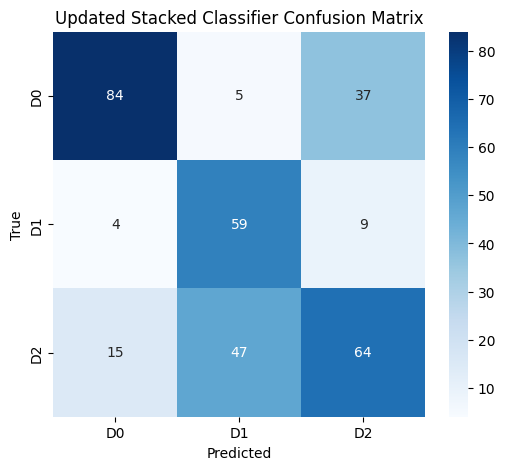

In [28]:
# Confusion matrix
cm_updated = confusion_matrix(y_test, y_pred_updated)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_updated, annot=True, fmt='d', cmap='Blues', xticklabels=test3_data.class_indices, yticklabels=test3_data.class_indices)
plt.title('Updated Stacked Classifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [29]:
# Accuracy
accuracy_updated = stack_model_updated.score(X_test_scaled, y_test)
print(f"Updated Stacked Classifier Accuracy: {accuracy_updated * 100:.2f}%")

Updated Stacked Classifier Accuracy: 63.89%
